In [1]:
%matplotlib widget
from dateutil.parser import parse as parse_date
import pandas as pd
from natsort import natsort_keygen

In [2]:
labels_csv_path = r"..\data\ESA-Mission1\labels.csv"
anomaly_types_path = r"..\data\ESA-Mission1\anomaly_types.csv"

labels_df: pd.DataFrame = pd.read_csv(labels_csv_path, parse_dates=["StartTime", "EndTime"])
labels_df["StartTime"] = labels_df["StartTime"].apply(lambda t: t.tz_localize(None))
labels_df["EndTime"] = labels_df["EndTime"].apply(lambda t: t.tz_localize(None))

anomaly_types_df: pd.DataFrame = pd.read_csv(anomaly_types_path)
columns_to_copy = anomaly_types_df.columns[[-6, -4]]
for col in columns_to_copy:
    labels_df[col] = ""
for _, row in anomaly_types_df.iterrows():
    labels_df.loc[labels_df["ID"] == row["ID"], columns_to_copy] = row[columns_to_copy].values

labels_df = labels_df.drop(columns=["Channel"])
start_times = labels_df.groupby(by="ID").min()["StartTime"]
end_times = labels_df.groupby(by="ID").max()["EndTime"]

labels_df = labels_df.groupby(by="ID").min()
labels_df["EndTime"] = end_times - labels_df["StartTime"]
labels_df.loc[labels_df["EndTime"] < pd.Timedelta(days=10), "EndTime"] = pd.Timedelta(days=10)
labels_df

,StartTime,EndTime,Class,Category
ID,,,,
id_1,2004-12-01 20:42:15.429,14 days 20:10:15,class_6,Rare Event
id_10,2005-03-31 08:14:58.125,10 days 00:00:00,class_9,Anomaly
id_100,2005-07-04 19:53:57.402,10 days 00:00:00,class_14,Rare Event
id_101,2005-09-01 14:42:10.107,11 days 09:17:32.286000,class_20,Anomaly
id_102,2005-09-27 21:39:20.604,10 days 00:00:00,class_20,Anomaly
...,...,...,...,...
id_95,2004-09-15 13:46:02.652,10 days 00:00:00,class_14,Rare Event
id_96,2004-11-03 14:35:25.152,10 days 00:00:00,class_15,Anomaly
id_97,2004-12-01 07:30:15.429,10 days 00:00:00,class_7,Anomaly


49

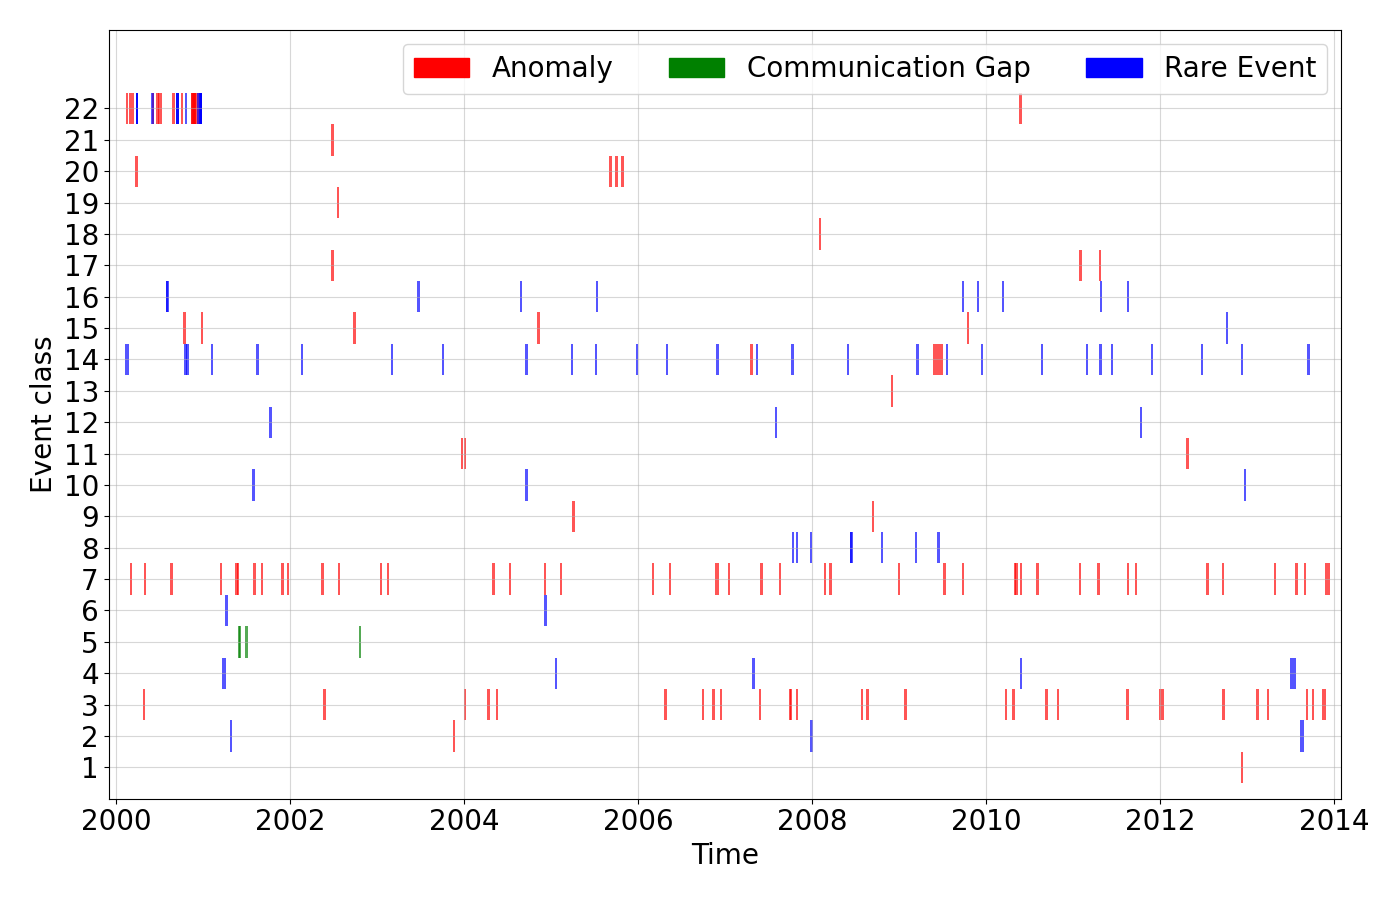

In [3]:
%matplotlib widget
import gc
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
plt.close("all")
plt.rcParams.update({'font.size': 20})
plt.rcParams["image.cmap"] = "Set2"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

plt.figure(figsize=(14,9))

unique_classes = labels_df.sort_values(by="Class", key=natsort_keygen())["Class"].unique()
colors_dict = {"Anomaly": "red", "Rare Event": "blue", "Communication Gap": "green"}

ax = plt.gca()
available_categories = set()
for i, cls in enumerate(unique_classes):
    categories = labels_df.loc[labels_df["Class"] == cls, "Category"]
    unique_categories = set(categories)
    available_categories.update(unique_categories)
    for cat in unique_categories:
        xranges = [(start, duration) for start, duration in labels_df.loc[((labels_df["Class"] == cls) & (labels_df["Category"] == cat)), ["StartTime", "EndTime"]].to_numpy()]
        ax.broken_barh(xranges, (i-0.5, 1), facecolors = colors_dict[cat], alpha=2/3)

handles = []
for cat in sorted(list(set(available_categories))):
    handles.append(Patch(color=colors_dict[cat], label=cat))
plt.legend(handles=handles, ncol=len(handles))
plt.xlim([parse_date("1999-12-01"),parse_date("2014-02-01")])
plt.ylim([-1,len(unique_classes)+1.5])
plt.yticks(ticks=range(len(unique_classes)), labels=[cls.split("_")[1] if cls != "unknown" else "?" for cls in unique_classes])
plt.xlabel("Time")
plt.ylabel("Event class")
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("mission1_timeline.svg")
gc.collect()
